## load packages, functions and data

In [285]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
import seaborn as sns

import os
import numpy as np
import pandas as pd

fs = 10

In [286]:
def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)
    
    class RadarTransform(PolarAxes.PolarTransform):
        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars, radius=0.5, edgecolor="k")
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

        def draw(self, renderer):
            """ Draw. If frame is polygon, make gridlines polygon-shaped """
            if frame == 'polygon':
                gridlines = self.yaxis.get_gridlines()
                for gl in gridlines:
                    gl.get_path()._interpolation_steps = num_vars
            super().draw(renderer)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

# ----------------------------------------------------------------
# color settings 
dic_color = dict({'Concrete': '#264653', 
                  'SteelFoundation': '#287271',
                  'Steel': '#2a9d8f',
                  'StainlessSteel': '#8ab17d',
                  'Aluminium': '#e9c46a', 
                  'Copper': '#efb366',
                  'else': '#efb366',  
                  'Plastics': '#f4a261',
                  'Insulation': '#ee8959',
                  'Painting': '#e76f51',
                  })

def _set_color(name):
    transp = 0.25 if 'recycling' in name else 1
    if 'recycling' in name:
        lbl_color = 'else' if 'other' in name else name.split(' ')[1]
    else:
        lbl_color = name 
    return transp, lbl_color

# translate units
trans_unit = dict({'Climate change ': '$10^{-2}$kg $CO_{2e}$', 
                   'Ozone depletion ': '$10^{-10}$kg $CFC{-11}_e$', 
                   'Particulate matter ': '$10^{-10}$ disease incidences',
                   'Acidification, terrestrial and freshwater ': '\n$10^{-4}$mole $H^+$ equiv.', 
                   'Eutrophication, freshwater ': '$10^{-6}$kg P equiv.', 
                   'Eutrophication, marine ': '$10^{-5}$kg N equiv.', 
                   'Eutrophication, terrestrial ': '$10^{-4}$mole N equiv.', 
                   'Ionizing radiation ': '$10^{-3}$ kbq $^{235}U$ equiv.', 
                   'Photochemical ozone formation ': '\n$10^{-5}$kg NMVOC equiv.', 
                   'Human toxicity, cancer ': '$10^{-10}$ CTUh', 
                   'Human toxicity, non-cancer ': '$10^{-10}$ CTUh', 
                   'Ecotoxicity, freshwater ': '$10^{-3}$ CTUe', 
                   'Land use ': '$10^{-1}$ Pt', 
                   'Water scarcity ': '$10^{-3}m^3$ world equiv.', 
                   'Resource depletion, energy ': '$10^{-1}MJ$', 
                   'Resource depletion, mineral and metals ': '$10^{-8}$kg Sb$_{e}$'
                   })

trans_label = dict({'Climate change ': 'Carbon Footprint', 
                   'Ozone depletion ': 'Ozone Depletion', 
                   'Particulate matter ': 'Particulate Matter',
                   'Acidification, terrestrial and freshwater ': 'Acidification, Terrestrial+Freshwater', 
                   'Eutrophication, freshwater ': 'Eutrophication·Freshwater', 
                   'Eutrophication, marine ': 'Eutrophication·Marine', 
                   'Eutrophication, terrestrial ': 'Eutrophication·Terrestrial', 
                   'Ionizing radiation ': 'Ionizing Radiation', 
                   'Photochemical ozone formation ': 'Photochem. Ozone Formation', 
                   'Human toxicity, cancer ': 'Human Toxicity·Cancer', 
                   'Human toxicity, non-cancer ': 'Human Toxicity·non-Cancer', 
                   'Ecotoxicity, freshwater ': 'Ecotoxicity·Freshwater', 
                   'Land use ': 'Land Use', 
                   'Water scarcity ': 'Water Scarcity', 
                   'Resource depletion, energy ': 'Resource Depletion·Energy', 
                   'Resource depletion, mineral and metals ': 'Resource Depletion·Mineral+Metals'
                   })

# ----------------------------------------------------------------
# load data
path_work = os.path.abspath(os.getcwd())
path_parent = '/'.join(path_work.split('/')[:-2])
path_save = path_parent + '/outputs/LCA_DAC/'
file_input = path_parent + '/inputs/LCA_DAC/data_LCA-DAC.xlsx'

df = pd.read_excel(file, sheet_name=None)
df_adsorb = df['EnvImpact_adsorbents']

## Adsorbent material

### spider web comparison - production vs end-of-life

In [24]:
df_adsorb2 = df['EnvImpact_adsorbents2']

grps = df_adsorb2.groupby('System Boundary')
df_prod = grps.get_group('Production')
df_eol = grps.get_group('End of Life')
df_tot = grps.get_group('Total carbon footprint')

ls_labels = ['Environmental impact ', 'Unit', 'Amine on silica ', 'Amine on alumina ', 'Amine on cellulose ', 'Carbonate on silica ',
             'Carbonate on activated carbon', 'Anionic resin ']
ls_materials2 = ['Amine on silica ', 'Amine on alumina ', 'Amine on cellulose ', 'Carbonate on silica ',
                 'Carbonate on activated carbon', 'Anionic resin ']

df_prod = df_prod[ls_labels].set_index(ls_labels[0])
df_eol = df_eol[ls_labels].set_index(ls_labels[0])
df_tot = df_tot[ls_labels].set_index(ls_labels[0])


In [25]:
# normalize data for better comparison on the spider web
df_prod_norm = df_prod[ls_materials2].T / df_tot[ls_materials2].max(axis=1)
df_prod_norm = df_prod_norm.T
df_eol_norm = df_eol[ls_materials2].T / df_tot[ls_materials2].max(axis=1)
df_eol_norm = df_eol_norm.T
df_tot_norm = df_tot[ls_materials2].T / df_tot[ls_materials2].max(axis=1)
df_tot_norm = df_tot_norm.T

#...............................................
title = 'Environmental Impact of different Adsorbent Materials'
lbl_material = [i.strip() for i in ls_materials2]
lbl_var = df_prod_norm.index
lbl_var = [i.strip() for i in lbl_var]
var = np.arange(len(lbl_var))
values = np.array(df_prod_norm.replace(np.nan, 0).T)
valuesT = np.array(df_tot_norm.replace(np.nan, 0).T)

data = [var, (title, values)]
dataT = [var, (title, valuesT)]

N = len(data[0])
theta = radar_factory(N, frame='polygon')
spoke_labels = data.pop(0)
spoke_labelsT = dataT.pop(0)
_, case_data = data[0]
_, case_dataT = dataT[0]

leg_text = [str(n) + ' ' + lbl for n, lbl in zip(var, lbl_var)]

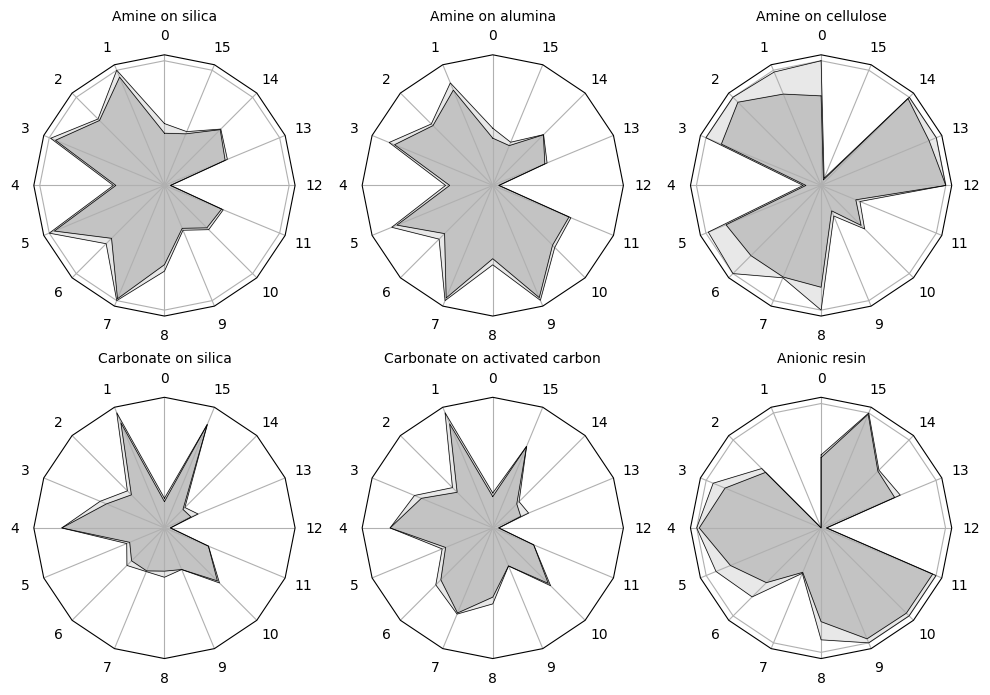

In [26]:
# normalized data (range 0-1) for comparison
fig, ax = plt.subplots(figsize=(10, 7), ncols=3, nrows=2, subplot_kw=dict(projection='radar'))
fig.subplots_adjust(top=0.85, bottom=0.05)

for en, ax in enumerate(fig.axes):
    ax.set_rgrids([0, 1, 2.0, 3.0, 4.0, 5.0, 6])
    ax.set_title(lbl_material[en], position=(0.5, 1.1), ha='center', fontsize=fs)

    line = ax.plot(theta, case_dataT[en], color='k', lw=0.5)
    ax.fill(theta, case_dataT[en], alpha=0.25, label='_nolegend_', color='#A6A6A6')
    
    line = ax.plot(theta, case_data[en], color='k', lw=0.5)
    ax.fill(theta, case_data[en], alpha=0.55, label='_nolegend_', color='#A6A6A6')
    
    ax.set_varlabels(spoke_labels)
    ax.set_yticklabels([])

plt.tight_layout()
plt.show()

# save figure
# fig.savefig(path_save + 'environmnetal_impact_adsorbents_EoL-vs-Production.png', dpi=300) # total

### carbon footprint · climate change

/var/folders/gx/0kp7488d3bzb4wrt22g3t94cfvyf8b/T/ipykernel_5517/260504913.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([0]+list(df_adsorb_CC.loc[ls_materials2].index), rotation=30)


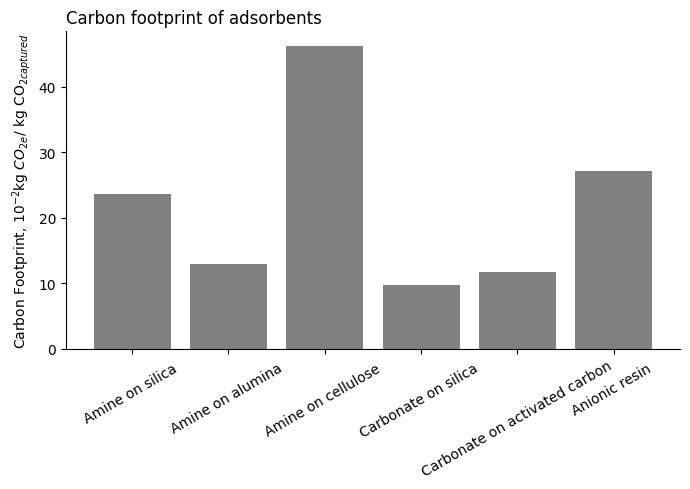

In [96]:
ic_para = 'Climate change '
df_adsorb_CC = df_tot.loc[ic_para, ls_materials2]

# .............................................................................
fig, ax = plt.subplots(figsize=(7, 5))
ax.set_title('Carbon footprint of adsorbents', loc='left')
ax.set_ylabel('{}, {}'.format(trans_label[ic_para].split('·')[0], trans_unit[ic_para]) + '/ kg CO$_{2 captured}$')
ax.bar(np.arange(len(df_adsorb_CC.loc[ls_materials2])), df_adsorb_CC.loc[ls_materials2].values, color='grey')

ax.set_xticklabels([0]+list(df_adsorb_CC.loc[ls_materials2].index), rotation=30)
sns.despine()
plt.tight_layout()

# .............................................................................
# save figure
#fig.savefig(path_save + ''.join(trans_label[ic_para].split(' ')) + '_adsborbents.png', dpi=300)

### Resource Depletion · Minerals+Metals

/var/folders/gx/0kp7488d3bzb4wrt22g3t94cfvyf8b/T/ipykernel_5517/210546119.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([0]+list(df_adsorb_RDM.loc[ls_materials2].index), rotation=30)


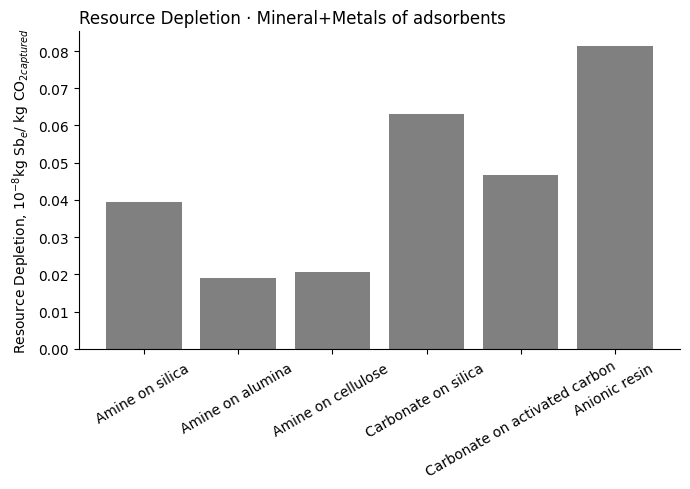

In [95]:
ic_para = 'Resource depletion, mineral and metals '
df_adsorb_RDM = df_tot.loc[ic_para, ls_materials2]

# .............................................................................
fig, ax = plt.subplots(figsize=(7, 5))
ax.set_title('Resource Depletion · Mineral+Metals of adsorbents', loc='left')
ax.set_ylabel('{}, {}'.format(trans_label[ic_para].split('·')[0], trans_unit[ic_para]) + '/ kg CO$_{2 captured}$')
ax.bar(np.arange(len(df_adsorb_RDM.loc[ls_materials2])), df_adsorb_RDM.loc[ls_materials2].values, color='grey')

ax.set_xticklabels([0]+list(df_adsorb_RDM.loc[ls_materials2].index), rotation=30)
sns.despine()
plt.tight_layout()

# .............................................................................
# save figure
#fig.savefig(path_save + ''.join(trans_label[ic_para].split(' ')) + '_adsborbents.png', dpi=300)

### other environmental impact categories

/var/folders/gx/0kp7488d3bzb4wrt22g3t94cfvyf8b/T/ipykernel_5517/3552246248.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([0]+list(df_ic.loc[ls_materials2].index), rotation=30)
/var/folders/gx/0kp7488d3bzb4wrt22g3t94cfvyf8b/T/ipykernel_5517/3552246248.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([0]+list(df_ic.loc[ls_materials2].index), rotation=30)
/var/folders/gx/0kp7488d3bzb4wrt22g3t94cfvyf8b/T/ipykernel_5517/3552246248.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([0]+list(df_ic.loc[ls_materials2].index), rotation=30)
/var/folders/gx/0kp7488d3bzb4wrt22g3t94cfvyf8b/T/ipykernel_5517/3552246248.py:10: UserWarning: set_ticklabels() should only be used with a fix

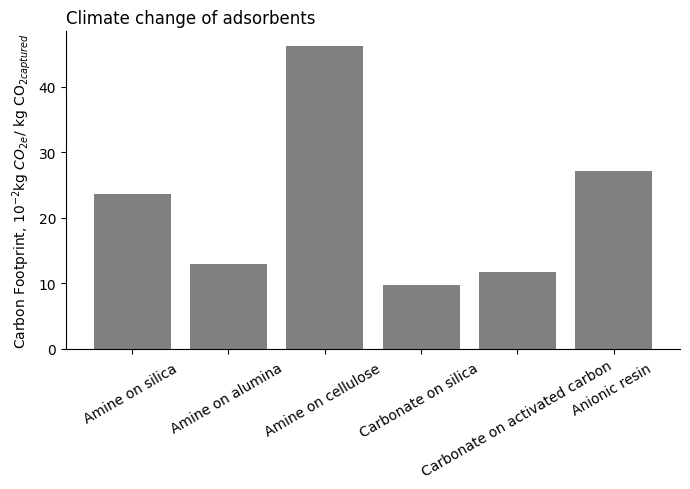

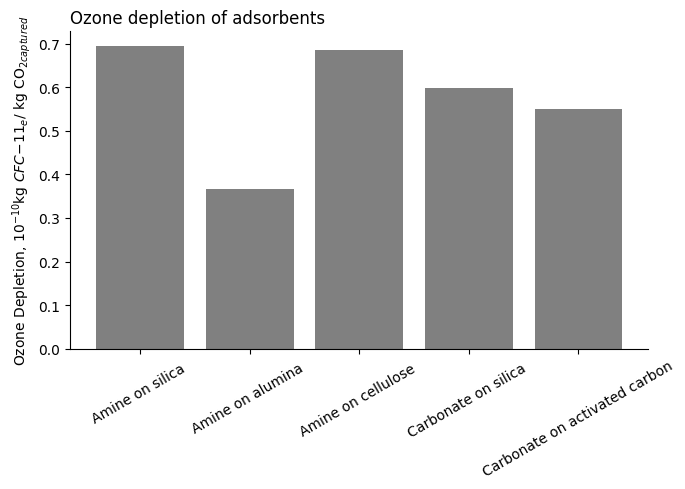

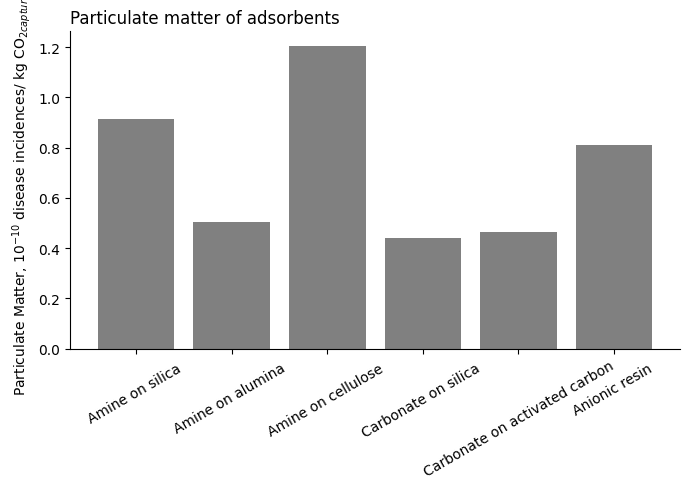

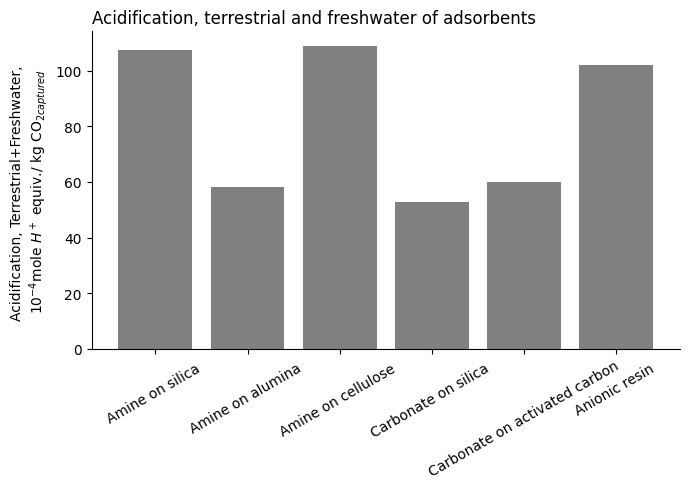

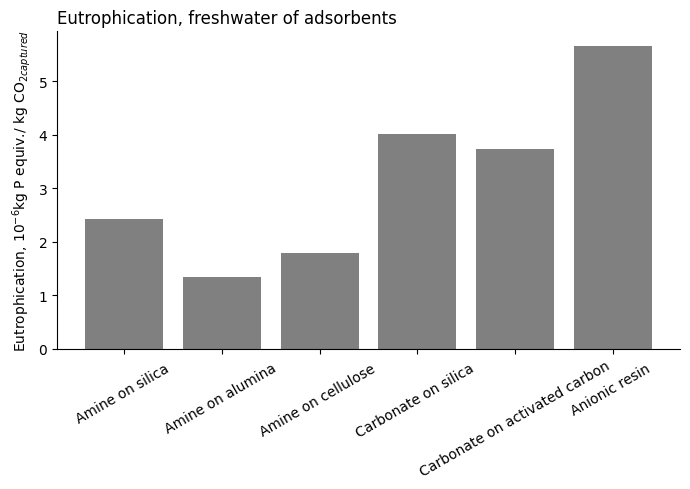

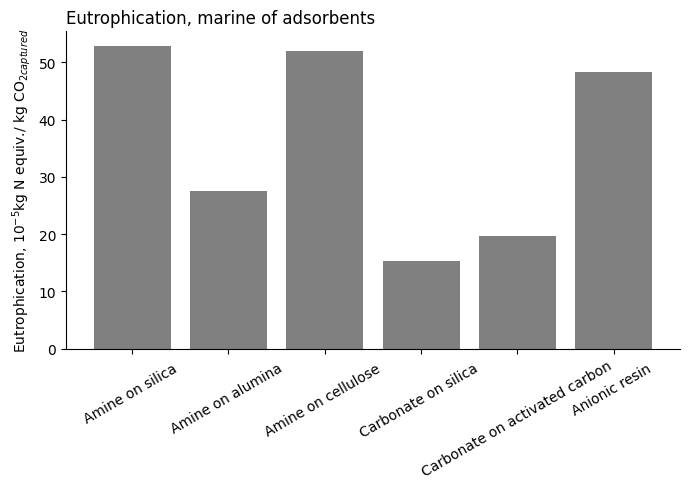

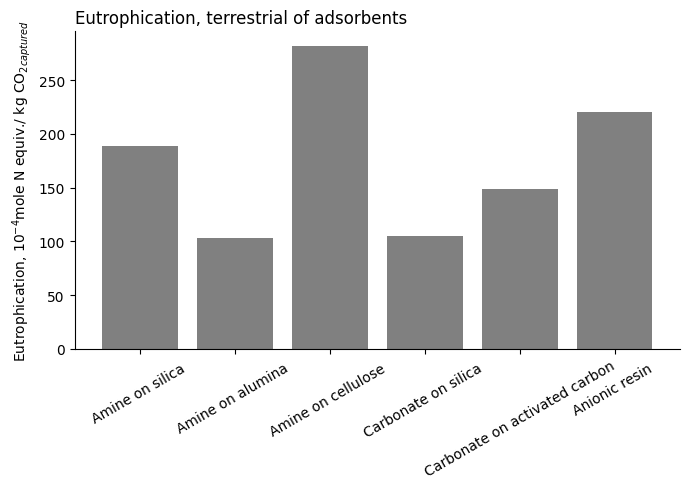

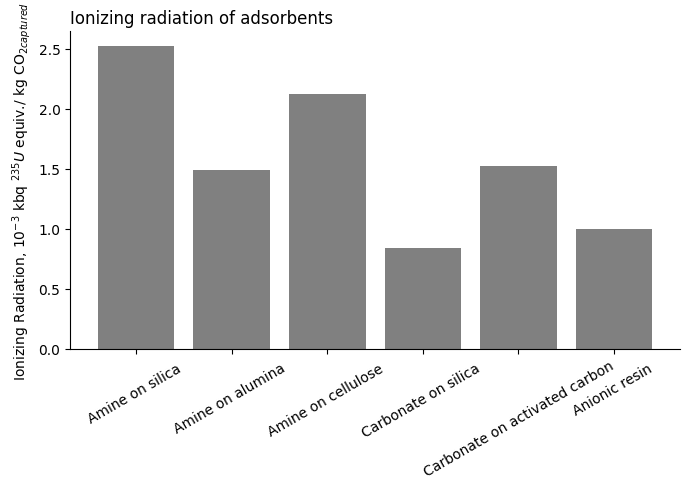

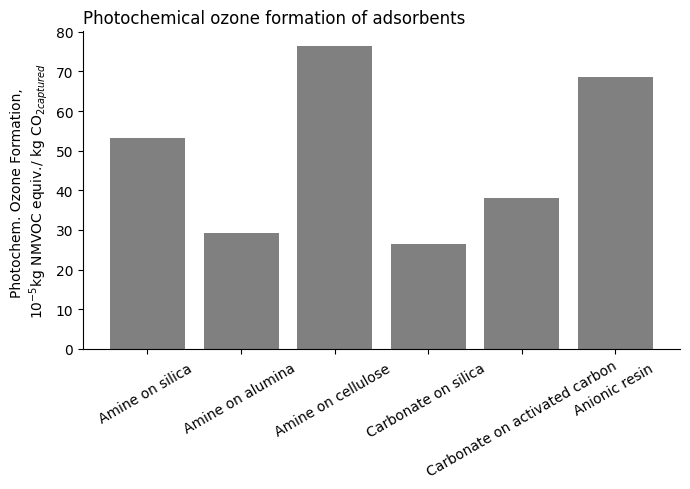

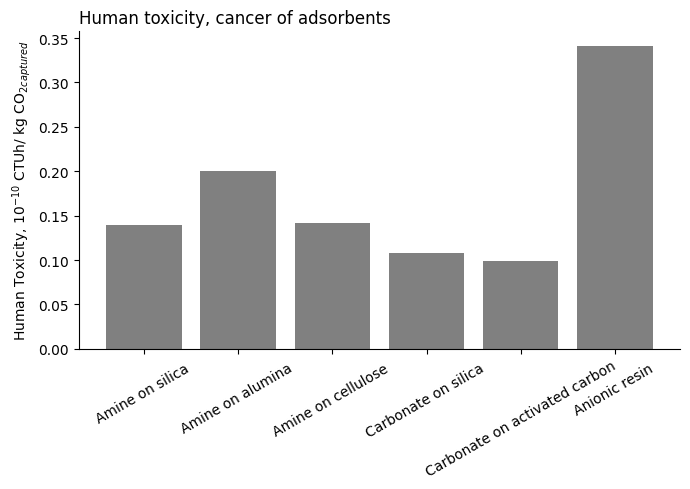

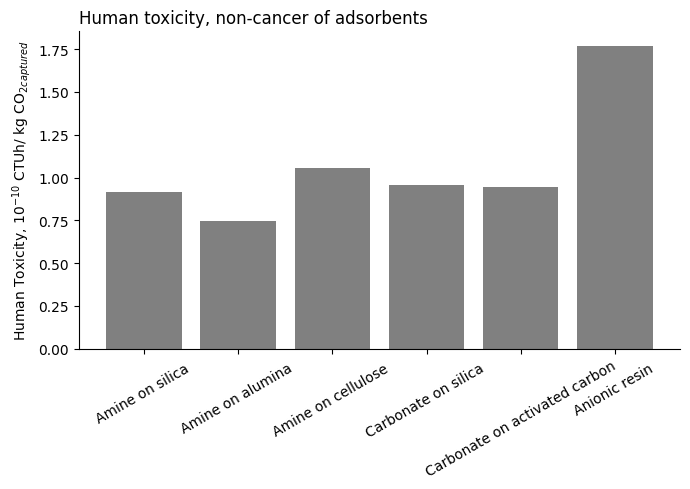

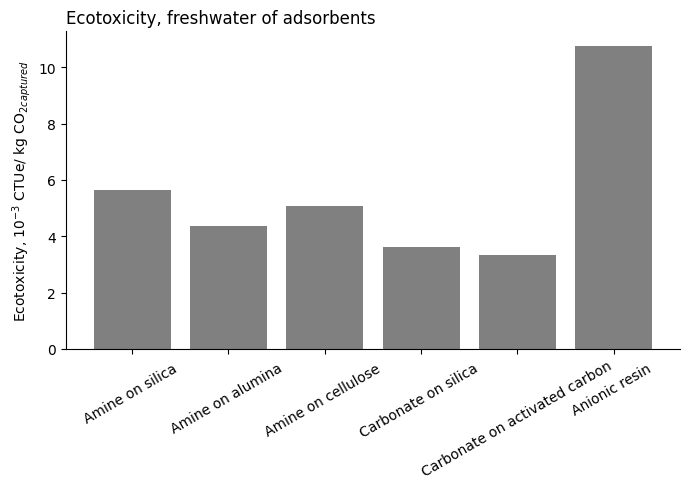

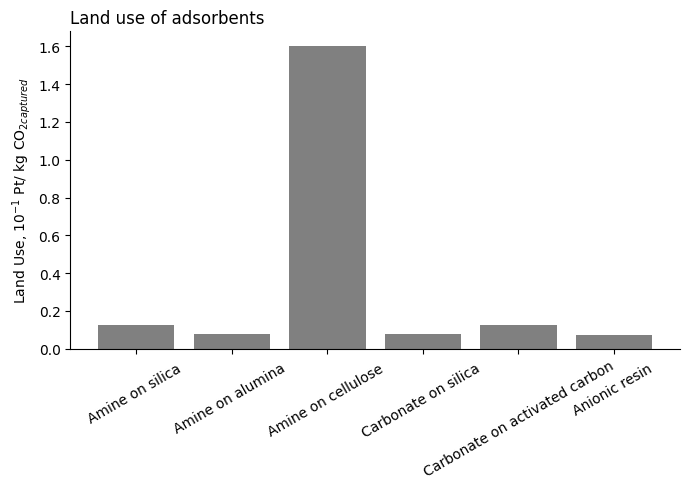

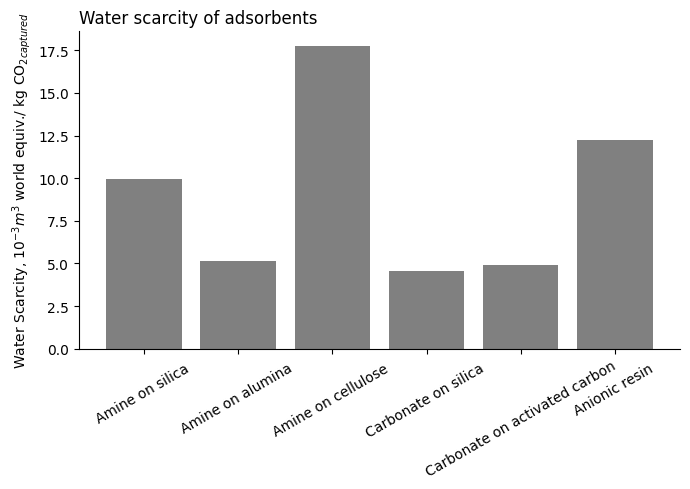

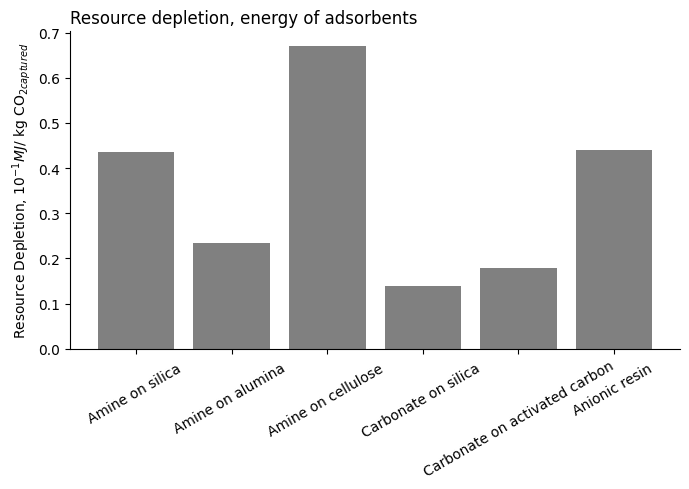

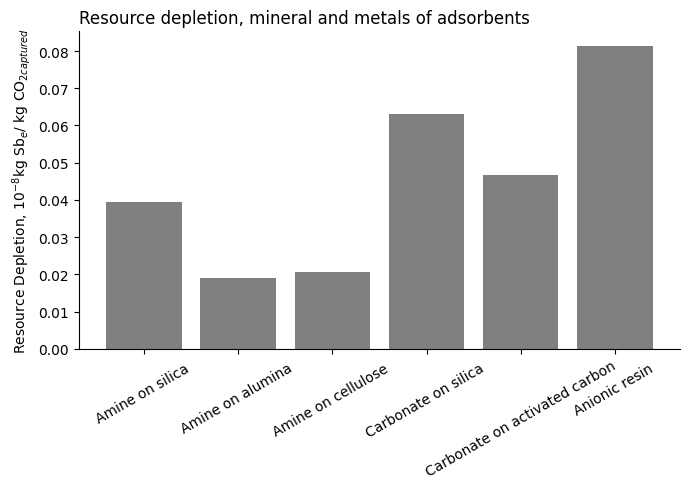

In [113]:
for ic in df_tot.index[1:-1]:
    df_ic = df_tot.loc[ic, ls_materials2]

    # .............................................................................
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.set_title(ic.strip() + ' of adsorbents', loc='left')
    ax.set_ylabel('{}, {}'.format(trans_label[ic].split('·')[0], trans_unit[ic]) + '/ kg CO$_{2 captured}$')
    ax.bar(np.arange(len(df_ic.loc[ls_materials2])), df_ic.loc[ls_materials2].values, color='grey')

    ax.set_xticklabels([0]+list(df_ic.loc[ls_materials2].index), rotation=30)
    sns.despine()
    plt.tight_layout()

    # .............................................................................
    # save figure
    fig.savefig(path_save + ''.join(trans_label[ic].split(' ')) + '_adsborbents.png', dpi=300)

## DAC plant construction

### BarChart and Breakdown

#### B1_CarbonFootprint

In [4]:
df_plant_CC = df['B1_CarbonFootprint']
df_plant_CC = df_plant_CC.set_index(df_plant_CC.columns[0])

ls_plant_element = list(df_plant_CC[df_plant_CC['individual_contribution'].isna()].index)

# general bar plot
ydata = df_plant_CC.loc[ls_plant_element, 'cummulative_value'].values
xdata = np.arange(len(ydata))

/var/folders/gx/0kp7488d3bzb4wrt22g3t94cfvyf8b/T/ipykernel_8867/1464888499.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([0]+ls_plant_element, rotation=30)


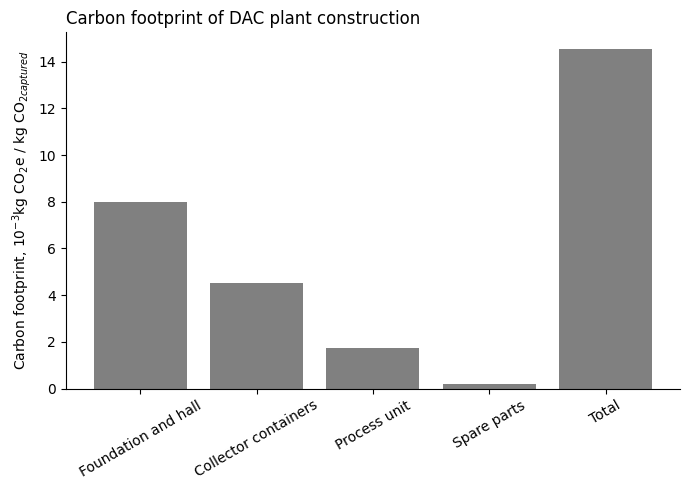

In [5]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.set_title('Carbon footprint of DAC plant construction', loc='left')
ax.set_ylabel('Carbon footprint, 10$^{-3}$kg CO$_{2}$e / kg CO$_{2 captured}$')

ax.bar(xdata, ydata, color='grey')
ax.set_xticklabels([0]+ls_plant_element, rotation=30)

sns.despine()
plt.tight_layout()

# save figure
#fig.savefig(path_save + 'climateChange_carbonFootprint_DACplant.png', transparent=True, dpi=300)

#### B1_CarbonFootprint | Breakdown

In [6]:
df1 = df_plant_CC.loc[ls_plant_element[0]:ls_plant_element[1], 'individual_contribution'].dropna()
df2 = df_plant_CC.loc[ls_plant_element[1]:ls_plant_element[2], 'individual_contribution'].dropna()
df3 = df_plant_CC.loc[ls_plant_element[2]:ls_plant_element[3], 'individual_contribution'].dropna()
df4 = df_plant_CC.loc[ls_plant_element[3]:ls_plant_element[4], 'individual_contribution'].dropna()
df5 = df_plant_CC.loc[ls_plant_element[4]:, 'individual_contribution'].dropna()

ydata1 = df1.values
ydata2 = df2.values
ydata3 = df3.values
ydata4 = df4.values
ydata5 = df5.values

lbl1 = list(df1.index)
lbl2 = list(df2.index)
lbl3 = list(df3.index)
lbl4 = list(df4.index)
lbl5 = list(df5.index)

/var/folders/gx/0kp7488d3bzb4wrt22g3t94cfvyf8b/T/ipykernel_8867/1492148528.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([0]+ls_plant_element, rotation=30)


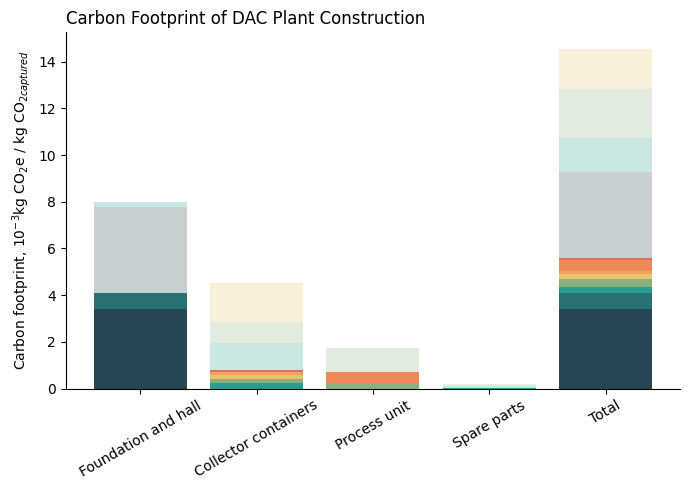

In [7]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.set_title('Carbon Footprint of DAC Plant Construction', loc='left')
ax.set_ylabel('Carbon footprint, 10$^{-3}$kg CO$_{2}$e / kg CO$_{2 captured}$')

for i in range(len((ydata5))):
    if i == 0:
        ax.bar([0], ydata1[i], color=dic_color[df1.index[0]]) 
        ax.bar([1], ydata2[i], color=dic_color[df2.index[0]])
        ax.bar([2], ydata3[i], color=dic_color[df3.index[0]])
        ax.bar([3], ydata4[i], color=dic_color[df4.index[0]])
        ax.bar([4], ydata5[i], color=dic_color[df5.index[0]])
    else:
        if i < len(ydata1):
            transp, lbl_color =  _set_color(name=df1.index[i])
            ax.bar([0], ydata1[i], bottom=sum(ydata1[:i]), color=dic_color[lbl_color], alpha=transp)
        if i < len(ydata2):
            transp, lbl_color =  _set_color(name=df2.index[i])
            ax.bar([1], ydata2[i], bottom=sum(ydata2[:i]), color=dic_color[lbl_color], alpha=transp)
        if i < len(ydata3):
            transp, lbl_color =  _set_color(name=df3.index[i])
            ax.bar([2], ydata3[i], bottom=sum(ydata3[:i]), color=dic_color[lbl_color], alpha=transp)
        if i < len(ydata4):
            transp, lbl_color =  _set_color(name=df4.index[i])
            ax.bar([3], ydata4[i], bottom=sum(ydata4[:i]), color=dic_color[lbl_color], alpha=transp)
        if i < len(ydata5):
            transp, lbl_color =  _set_color(name=df5.index[i])
            ax.bar([4], ydata5[i], bottom=sum(ydata5[:i]), color=dic_color[lbl_color], alpha=transp)
     
ax.set_xticklabels([0]+ls_plant_element, rotation=30)

#ax.set_ylim(0, .5)
sns.despine()
plt.tight_layout()

# save figure
#fig.savefig(path_save + 'climateChange_carbonFootprint_DACplant_breaktdown_SparPartFocus.png', transparent=True, dpi=300)

#### B2_ozoneDepletion

In [8]:
df_plant_oD = df['B2_ozoneDepletion']
df_plant_oD = df_plant_oD.set_index(df_plant_oD.columns[0])

# general bar plot
ydata = df_plant_oD.loc[ls_plant_element, 'cummulative_value'].values
xdata = np.arange(len(ydata))


/var/folders/gx/0kp7488d3bzb4wrt22g3t94cfvyf8b/T/ipykernel_8867/2211845298.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([0]+ls_plant_element, rotation=30)


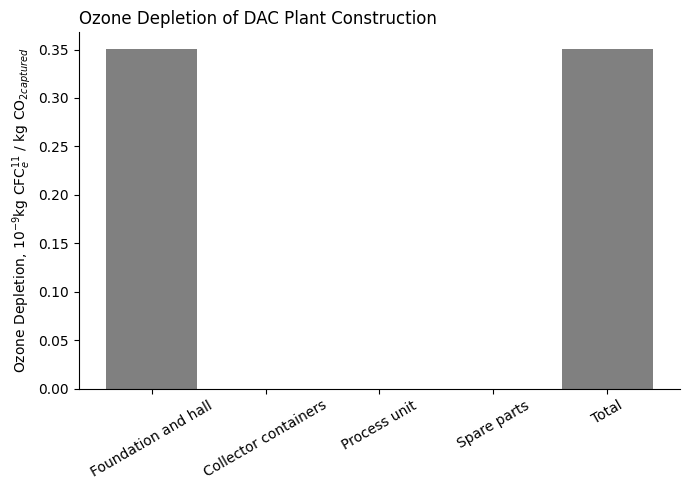

In [9]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.set_title('Ozone Depletion of DAC Plant Construction', loc='left')
ax.set_ylabel('Ozone Depletion, 10$^{-9}$kg CFC$^{11}_e$ / kg CO$_{2 captured}$')

ax.bar(xdata, ydata, color='grey')
ax.set_xticklabels([0]+ls_plant_element, rotation=30)

sns.despine()
plt.tight_layout()

# save figure
#fig.savefig(path_save + 'ozoneDepletion_DACplant.png', transparent=True, dpi=300)

In [10]:
df1 = df_plant_oD.loc[ls_plant_element[0]:ls_plant_element[1], 'individual_contribution'].dropna()
df2 = df_plant_oD.loc[ls_plant_element[1]:ls_plant_element[2], 'individual_contribution'].dropna()
df3 = df_plant_oD.loc[ls_plant_element[2]:ls_plant_element[3], 'individual_contribution'].dropna()
df4 = df_plant_oD.loc[ls_plant_element[3]:ls_plant_element[4], 'individual_contribution'].dropna()
df5 = df_plant_oD.loc[ls_plant_element[4]:, 'individual_contribution'].dropna()

ydata1 = df1.values
ydata2 = df2.values
ydata3 = df3.values
ydata4 = df4.values
ydata5 = df5.values

lbl1 = list(df1.index)
lbl2 = list(df2.index)
lbl3 = list(df3.index)
lbl4 = list(df4.index)
lbl5 = list(df5.index)

#### B2_ozoneDepletion | Breakdown

/var/folders/gx/0kp7488d3bzb4wrt22g3t94cfvyf8b/T/ipykernel_8867/1101618874.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([0]+ls_plant_element, rotation=30)


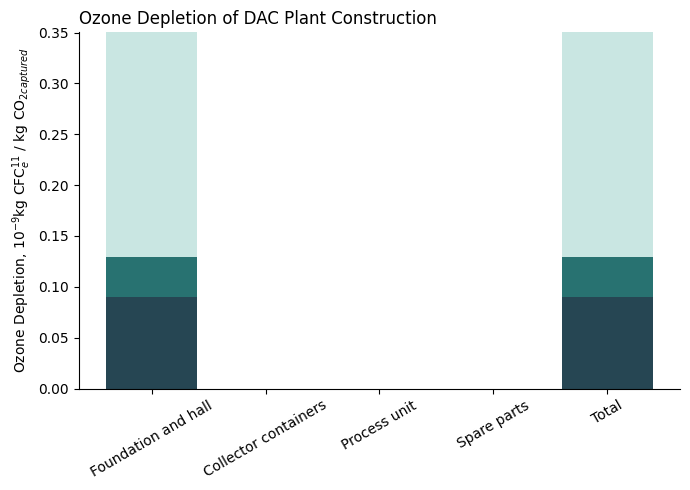

In [11]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.set_title('Ozone Depletion of DAC Plant Construction', loc='left')
ax.set_ylabel('Ozone Depletion, 10$^{-9}$kg CFC$^{11}_e$ / kg CO$_{2 captured}$')

for i in range(len((ydata5))):
    if i == 0:
        ax.bar([0], ydata1[i], color=dic_color[df1.index[0]]) 
        ax.bar([1], ydata2[i], color=dic_color[df2.index[0]])
        ax.bar([2], ydata3[i], color=dic_color[df3.index[0]])
        ax.bar([3], ydata4[i], color=dic_color[df4.index[0]])
        ax.bar([4], ydata5[i], color=dic_color[df5.index[0]])
    else:
        if i < len(ydata1):
            transp, lbl_color =  _set_color(name=df1.index[i])
            ax.bar([0], ydata1[i], bottom=sum(ydata1[:i]), color=dic_color[lbl_color], alpha=transp)
        if i < len(ydata2): 
            transp, lbl_color =  _set_color(name=df2.index[i])
            ax.bar([1], ydata2[i], bottom=sum(ydata2[:i]), color=dic_color[lbl_color], alpha=transp)
        if i < len(ydata3):
            transp, lbl_color =  _set_color(name=df3.index[i])
            ax.bar([2], ydata3[i], bottom=sum(ydata3[:i]), color=dic_color[lbl_color], alpha=transp)
        if i < len(ydata4):
            transp, lbl_color =  _set_color(name=df4.index[i])
            ax.bar([3], ydata4[i], bottom=sum(ydata4[:i]), color=dic_color[lbl_color], alpha=transp)
        if i < len(ydata5):
            transp, lbl_color =  _set_color(name=df5.index[i])
            ax.bar([4], ydata5[i], bottom=sum(ydata5[:i]), color=dic_color[lbl_color], alpha=transp)
     
ax.set_xticklabels([0]+ls_plant_element, rotation=30)

#ax.set_ylim(0, .5)
sns.despine()
plt.tight_layout()

# save figure
#fig.savefig(path_save + 'ozoneDepletion_DACplant_breaktdown.png', transparent=True, dpi=300)

#### B3_particulateMatter

In [22]:
df_plant_pM = df['B3_particulateMatter']
df_plant_pM = df_plant_pM.set_index(df_plant_pM.columns[0])

# general bar plot
ydata = df_plant_pM.loc[ls_plant_element, 'cummulative_value'].values
xdata = np.arange(len(ydata))

/var/folders/gx/0kp7488d3bzb4wrt22g3t94cfvyf8b/T/ipykernel_21927/1996780417.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([0]+ls_plant_element, rotation=30)


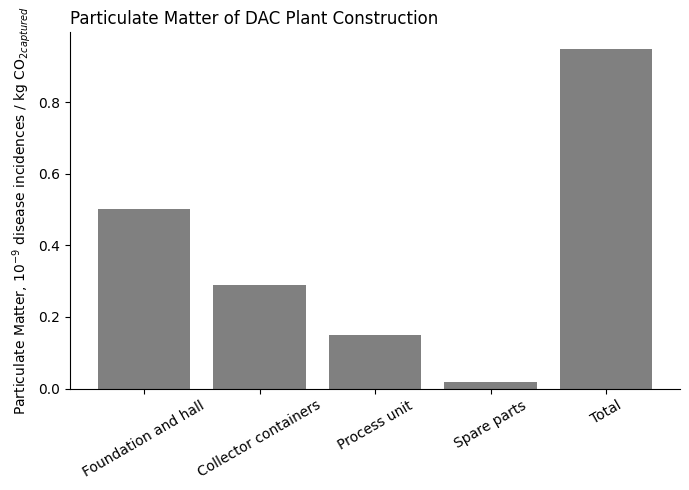

In [24]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.set_title('Particulate Matter of DAC Plant Construction', loc='left')
ax.set_ylabel('Particulate Matter, 10$^{-9}$ disease incidences / kg CO$_{2 captured}$')

ax.bar(xdata, ydata, color='grey')
ax.set_xticklabels([0]+ls_plant_element, rotation=30)

sns.despine()
plt.tight_layout()

# save figure
#fig.savefig(path_save + 'particulateMatter_DACplant.png', transparent=True, dpi=300)

In [28]:
df1 = df_plant_pM.loc[ls_plant_element[0]:ls_plant_element[1], 'individual_contribution'].dropna()
df2 = df_plant_pM.loc[ls_plant_element[1]:ls_plant_element[2], 'individual_contribution'].dropna()
df3 = df_plant_pM.loc[ls_plant_element[2]:ls_plant_element[3], 'individual_contribution'].dropna()
df4 = df_plant_pM.loc[ls_plant_element[3]:ls_plant_element[4], 'individual_contribution'].dropna()
df5 = df_plant_pM.loc[ls_plant_element[4]:, 'individual_contribution'].dropna()

ydata1 = df1.values
ydata2 = df2.values
ydata3 = df3.values
ydata4 = df4.values
ydata5 = df5.values

lbl1 = list(df1.index)
lbl2 = list(df2.index)
lbl3 = list(df3.index)
lbl4 = list(df4.index)
lbl5 = list(df5.index)

#### B3_particulateMatter | Breakdown

/var/folders/gx/0kp7488d3bzb4wrt22g3t94cfvyf8b/T/ipykernel_21927/3634343601.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([0]+ls_plant_element, rotation=30)


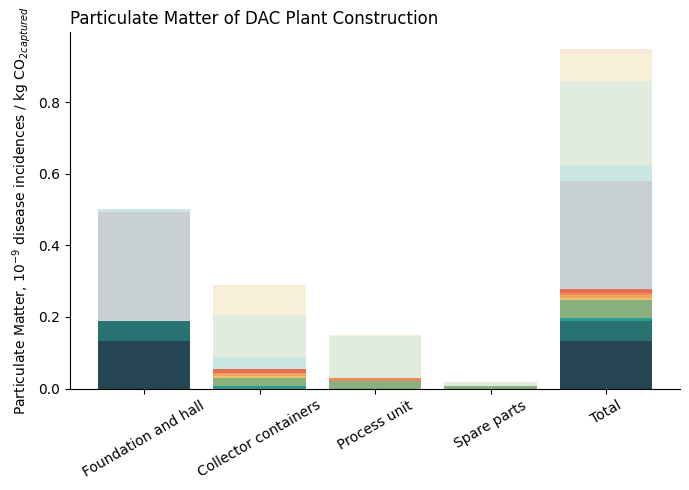

In [30]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.set_title('Particulate Matter of DAC Plant Construction', loc='left')
ax.set_ylabel('Particulate Matter, 10$^{-9}$ disease incidences / kg CO$_{2 captured}$')

for i in range(len((ydata5))):
    if i == 0:
        ax.bar([0], ydata1[i], color=dic_color[df1.index[0]]) 
        ax.bar([1], ydata2[i], color=dic_color[df2.index[0]])
        ax.bar([2], ydata3[i], color=dic_color[df3.index[0]])
        ax.bar([3], ydata4[i], color=dic_color[df4.index[0]])
        ax.bar([4], ydata5[i], color=dic_color[df5.index[0]])
    else:
        if i < len(ydata1):
            transp, lbl_color =  _set_color(name=df1.index[i])
            ax.bar([0], ydata1[i], bottom=sum(ydata1[:i]), color=dic_color[lbl_color], alpha=transp)
        if i < len(ydata2): 
            transp, lbl_color =  _set_color(name=df2.index[i])
            ax.bar([1], ydata2[i], bottom=sum(ydata2[:i]), color=dic_color[lbl_color], alpha=transp)
        if i < len(ydata3):
            transp, lbl_color =  _set_color(name=df3.index[i])
            ax.bar([2], ydata3[i], bottom=sum(ydata3[:i]), color=dic_color[lbl_color], alpha=transp)
        if i < len(ydata4):
            transp, lbl_color =  _set_color(name=df4.index[i])
            ax.bar([3], ydata4[i], bottom=sum(ydata4[:i]), color=dic_color[lbl_color], alpha=transp)
        if i < len(ydata5):
            transp, lbl_color =  _set_color(name=df5.index[i])
            ax.bar([4], ydata5[i], bottom=sum(ydata5[:i]), color=dic_color[lbl_color], alpha=transp)
     
ax.set_xticklabels([0]+ls_plant_element, rotation=30)

#ax.set_ylim(0, .5)
sns.despine()
plt.tight_layout()

# save figure
#fig.savefig(path_save + 'particulateMatter_DACplant_breaktdown.png', transparent=True, dpi=300)

#### other environmental impact categories - including breakdown

In [122]:
def prep4plotting(k, dpara, df):
    parameter = dpara[k.split('_')[1]][0]
    df_plant_EIC = df[k]
    df_plant_EIC = df_plant_EIC.set_index(df_plant_EIC.columns[0])

    unit = df_plant_EIC['Unit '][0].strip()
    ls_plant_element = list(df_plant_EIC[df_plant_EIC['individual_contribution'].isna()].index)


    # general bar plot
    ydata = df_plant_EIC.loc[ls_plant_element, 'cummulative_value'].values
    xdata = np.arange(len(ydata))

    df1 = df_plant_EIC.loc[ls_plant_element[0]:ls_plant_element[1], 'individual_contribution'].dropna()
    df2 = df_plant_EIC.loc[ls_plant_element[1]:ls_plant_element[2], 'individual_contribution'].dropna()
    df3 = df_plant_EIC.loc[ls_plant_element[2]:ls_plant_element[3], 'individual_contribution'].dropna()
    df4 = df_plant_EIC.loc[ls_plant_element[3]:ls_plant_element[4], 'individual_contribution'].dropna()
    df5 = df_plant_EIC.loc[ls_plant_element[4]:, 'individual_contribution'].dropna()

    ydata1 = df1.values
    ydata2 = df2.values
    ydata3 = df3.values
    ydata4 = df4.values
    ydata5 = df5.values

    lbl1 = list(df1.index)
    lbl2 = list(df2.index)
    lbl3 = list(df3.index)
    lbl4 = list(df4.index)
    lbl5 = list(df5.index)

    ddata = dict({0: (xdata, ydata), 1: (df1, ydata1, lbl1), 2: (df2, ydata2, lbl2), 3: (df3, ydata3, lbl3), 4: (df4, ydata4, lbl4), 5: (df5, ydata5, lbl5)})
    return parameter, ddata, unit, ls_plant_element


def plot_EnvImpactCategory(parameter, ddata, unit, ls_plant_element, path_save=None, save=False):
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.set_title('{} of DAC Plant Construction'.format(parameter), loc='left')
    ax.set_ylabel('{}, {}'.format(parameter, unit))
    
    ax.bar(ddata[0][0], ddata[0][1], color='grey')
    ax.set_xticklabels([0]+ls_plant_element, rotation=30)

    sns.despine()
    plt.tight_layout()

    # save figure
    if save is True:
        if path_save:
            fig.savefig(path_save + '{}_DACplant.png'.format(parameter.replace(" ", "")), transparent=True, dpi=300)
            print('save LCA EIC done.')
            

def plot_breakdown(parameter, unit, ddata, dic_color, ls_plant_element, path_save=None, save=False):
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.set_title('{} of DAC Plant Construction'.format(parameter), loc='left')
    ax.set_ylabel('{}, {}'.format(parameter, unit))

    for i in range(len((ddata[5][1]))):
        if i == 0:
            ax.bar([0], ddata[1][1][i], color=dic_color[ddata[1][0].index[0]]) 
            ax.bar([1], ddata[2][1][i], color=dic_color[ddata[2][0].index[0]])
            ax.bar([2], ddata[3][1][i], color=dic_color[ddata[3][0].index[0]])
            ax.bar([3], ddata[4][1][i], color=dic_color[ddata[4][0].index[0]])
            ax.bar([4], ddata[5][1][i], color=dic_color[ddata[5][0].index[0]])
        else:
            if i < len(ddata[1][1]):
                transp, lbl_color =  _set_color(name=ddata[1][0].index[i])
                ax.bar([0], ddata[1][1][i], bottom=sum(ddata[1][1][:i]), color=dic_color[lbl_color], alpha=transp)
            if i < len(ddata[2][1]): 
                transp, lbl_color =  _set_color(name=ddata[2][0].index[i])
                ax.bar([1], ddata[2][1][i], bottom=sum(ddata[2][1][:i]), color=dic_color[lbl_color], alpha=transp)
            if i < len(ddata[3][1]):
                transp, lbl_color =  _set_color(name=ddata[3][0].index[i])
                ax.bar([2], ddata[3][1][i], bottom=sum(ddata[3][1][:i]), color=dic_color[lbl_color], alpha=transp)
            if i < len(ddata[4][1]):
                transp, lbl_color =  _set_color(name=ddata[4][0].index[i])
                ax.bar([3], ddata[4][1][i], bottom=sum(ddata[4][1][:i]), color=dic_color[lbl_color], alpha=transp)
            if i < len(ddata[5][1]):
                transp, lbl_color =  _set_color(name=ddata[5][0].index[i])
                ax.bar([4], ddata[5][1][i], bottom=sum(ddata[5][1][:i]), color=dic_color[lbl_color], alpha=transp)
            
    ax.set_xticklabels([0]+ls_plant_element, rotation=30)

    #ax.set_ylim(0, .5)
    sns.despine()
    plt.tight_layout()

    # save figure
    if save is True:
        if path_save:
            fig.savefig(path_save + '{}_DACplant_breaktdown.png'.format(parameter.replace(" ", "")), transparent=True, dpi=300)
            print('save breakdown done.')

/var/folders/gx/0kp7488d3bzb4wrt22g3t94cfvyf8b/T/ipykernel_6889/4061617767.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  unit = df_plant_EIC['Unit '][0].strip()
/var/folders/gx/0kp7488d3bzb4wrt22g3t94cfvyf8b/T/ipykernel_6889/4061617767.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([0]+ls_plant_element, rotation=30)
/var/folders/gx/0kp7488d3bzb4wrt22g3t94cfvyf8b/T/ipykernel_6889/4061617767.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([0]+ls_plant_element, rotation=30)


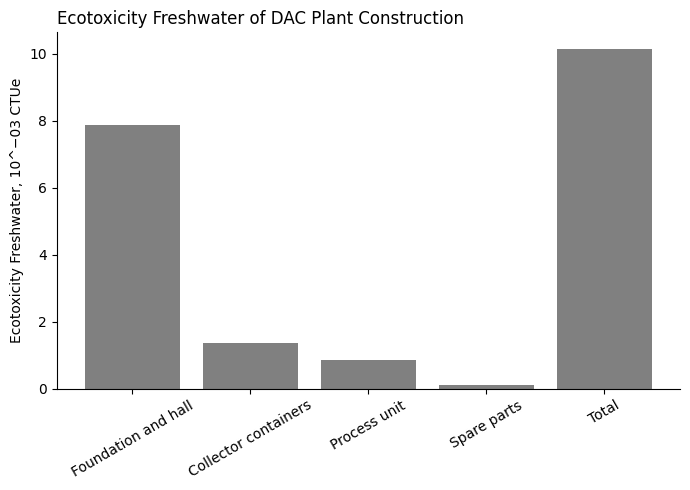

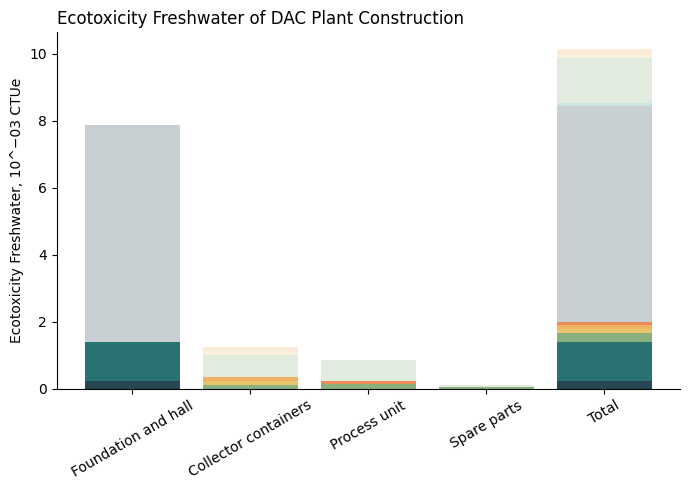

In [123]:
ls_para_rem = list(df.keys())[23:]

# parameter translation
dpara = dict({'acidification': ('Acidification',),
      'eutrophFreshwater': ('Eutrophication Freshwater',),
      'eutrophTerrest': ('Eutrophication Terrestrial',),
      'eutrophMarine': ('Eutrophication Marine',),
      'ionizingRadiation': ('Ionizing Radiation',),
      'photochemicalOzone': ('Photochemical Ozone',),
      'HumanToxCancer': ('Human Toxicity Cancer',),
      'HumanToxNCancer': ('Human Toxicity Non-Cancer',),
      'EcotoxFreshwater': ('Ecotoxicity Freshwater',),
      'LandUse': ('Land use',),
      'WaterScarcity': ('Water scarcity',),
      'ResourceDeplEnergy': ('Resource Depletion · Energy',),
      'ResourceDeplMinMet': ('Resource Depletion · Mineral+Metal', ),
      })

# -----------------------------------------------------------------------------------------------------
for k in ls_para_rem[8:9]:
    parameter, ddata, unit, ls_plant_element = prep4plotting(k=k, dpara=dpara, df=df)
    plot_EnvImpactCategory(parameter=parameter, ddata=ddata, unit=unit, ls_plant_element=ls_plant_element, path_save=path_save, save=False)
    plot_breakdown(parameter=parameter, unit=unit, ddata=ddata, dic_color=dic_color, ls_plant_element=ls_plant_element, path_save=path_save, save=False)

### Spider Chart DAC Plant Construction

In [104]:
df_plant = df['DAC_plant'].loc[23:]
df_plant.set_index(df_plant.columns[1], inplace=True)
df_plant = df_plant.T.set_index(df_plant.T.columns[0]).T

ls_systemBound = list(df_plant['System Boundary'].unique())
ls_plant_analysis = list(df_plant.columns[3:-2])

dic_plant_systemB = dict({ls_systemBound[0]: df_plant[df_plant['System Boundary'] == ls_systemBound[0]][ls_plant_analysis],
                          ls_systemBound[1]: df_plant[df_plant['System Boundary'] == ls_systemBound[1]][ls_plant_analysis]})

dic_plant_sysBnorm = dict({ls_systemBound[0]: pd.concat([pd.DataFrame([dic_plant_systemB[ls_systemBound[0]].loc[eic, p]/ np.nanmax(dic_plant_systemB[ls_systemBound[0]].loc[eic]) for p in ls_plant_analysis], 
                                                                      index=ls_plant_analysis, columns=[eic]).T 
                                                         for eic in df_plant.index.unique()]), 
                           ls_systemBound[1]: pd.concat([pd.DataFrame([dic_plant_systemB[ls_systemBound[1]].loc[eic, p]/ np.nanmax(dic_plant_systemB[ls_systemBound[1]].loc[eic]) for p in ls_plant_analysis], 
                                                                      index=ls_plant_analysis, columns=[eic]).T 
                                                         for eic in df_plant.index.unique()])})
dic_plant_sysBnorm['total'].head()

,Foundation + Hall,Collector Containers,Process Unit,Spare Parts
Climate change,1.0,0.573755,0.220307,0.023515
Ozone depletion,1.0,0.000000,0.000000,0.000000
Particulate matter,1.0,0.575000,0.298750,0.036250
"Acidification, terrestrial and freshwater",1.0,0.723333,0.278333,0.031667
"Eutrophication, freshwater",1.0,0.000000,0.000000,0.000000


In [119]:
title = 'Environmental Impact of different steps during DAC construction'

ls_webs_label = dic_plant_sysBnorm[ls_systemBound[0]].columns
lbl_webs = [i.strip() for i in ls_webs_label]
lbl_var = dic_plant_sysBnorm[ls_systemBound[0]].index
lbl_var = [i.strip() for i in lbl_var]
var = np.arange(len(lbl_var))

valuesT = np.array(dic_plant_sysBnorm[ls_systemBound[0]].replace(np.nan, 0).T)
dataT = [var, (title, valuesT)]
valuesR = np.array(dic_plant_sysBnorm[ls_systemBound[1]].replace(np.nan, 0).T)
dataR= [var, (title, valuesR)]

N = len(dataT[0])
theta = radar_factory(N, frame='polygon')

spoke_labelsT = dataT.pop(0)
_, case_dataT = dataT[0]
spoke_labelsR = dataR.pop(0)
_, case_dataR = dataR[0]

leg_text = [str(n) + ' ' + lbl for n, lbl in zip(var, lbl_var)]
lbl_var

['Climate change',
 'Ozone depletion',
 'Particulate matter',
 'Acidification, terrestrial and freshwater',
 'Eutrophication, freshwater',
 'Eutrophication, marine',
 'Eutrophication, terrestrial',
 'Ionizing radiation',
 'Photochemical ozone formation',
 'Human toxicity, cancer',
 'Human toxicity, non-cancer',
 'Ecotoxicity, freshwater',
 'Land use',
 'Water scarcity',
 'Resource depletion, energy',
 'Resource depletion, mineral and metals']

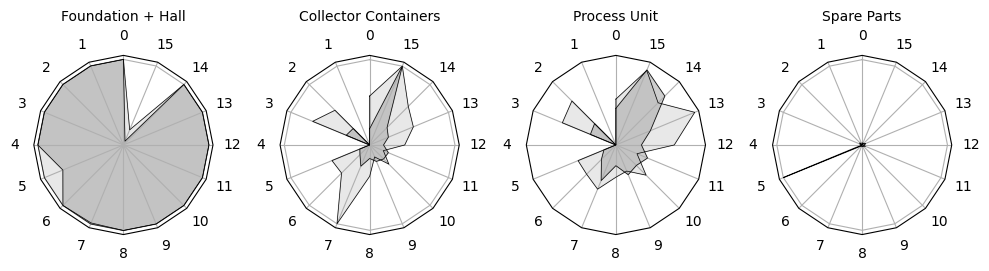

In [113]:
# normalized data (range 0-1) for comparison
fig, ax = plt.subplots(figsize=(10, 7), ncols=4, subplot_kw=dict(projection='radar'))
fig.subplots_adjust(top=0.85, bottom=0.05)

for en, ax in enumerate(fig.axes):
    ax.set_rgrids([0, 1, 2.0, 3.0, 4.0, 5.0, 6])
    ax.set_title(lbl_webs[en], position=(0.5, 1.1), ha='center', fontsize=fs)
    
    # total impact within a specifc environmental impact category
    line = ax.plot(theta, case_dataT[en], color='k', lw=0.5)
    ax.fill(theta, case_dataT[en], alpha=0.25, label='_nolegend_', color='#A6A6A6')
    
    # impact when considering recycling
    line = ax.plot(theta, case_dataR[en], color='k', lw=0.5)
    ax.fill(theta, case_dataR[en], alpha=0.55, label='_nolegend_', color='#A6A6A6')
     
    ax.set_varlabels(spoke_labelsT)
    ax.set_yticklabels([])

plt.tight_layout()
plt.show()

# save figure
# fig.savefig(path_save + 'environmnetal_impact_adsorbents_DACPlantConstruction_considerRecycling.png', dpi=300) # total

## Sensitivity Study - adsorbent; spider chart

In [344]:
df_sens = df['SensitivityStudy_adsorbent']
df_sens = df_sens.loc[:50,:]
df_sens.set_index('Environmental impact ')

ls_colSelect = ['Environmental impact ', 'Unit', 'base case scenario_normalized', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 
                'worst case_normalized', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23']
df_senS_ = df_sens[df_sens['System Boundary'] == 'Total carbon footprint'][ls_colSelect]
df_senS_.columns = ['Environmental Impact', 'Unit', 'Amine on Silica base case', 'Amine on Aluminia base case',
                    'Amine on Cellulose base case', 'Anionic Resin base case', 'Amine on Silica worst case', 
                    'Amine on Aluminia worst case', 'Amine on Cellulose worst case', 'Anionic Resin worst case']

df_senS = df_senS_.set_index('Environmental Impact')

df_base = df_senS.filter(like='base')
df_worst = df_senS.filter(like='worst')
ls_material3 = [i.split(' base')[0] for i in df_base.columns]

# normalize data for better comparison on the spider web >> or shall it be the absolute max
#df_base_norm = df_base.T / df_senS.filter(like=df_base.columns[0].split(' base')[0]).max(axis=1) #df_base.max(axis=1)
#df_base_norm = df_base_norm.T
df_base_norm = pd.concat([df_base.filter(like=c.split(' base')[0]).T / df_senS[df_senS.columns[1:]].max(axis=1) 
                          for c in df_base.columns]).T

#df_worst_norm = df_worst.T / df_senS.filter(like=df_base.columns[0].split(' base')[0]).max(axis=1) #df_worst.max(axis=1)
#df_worst_norm = df_worst_norm.T
df_worst_norm = pd.concat([df_worst.filter(like=c.split(' base')[0]).T / df_senS[df_senS.columns[1:]].max(axis=1) 
                          for c in df_worst.columns]).T

In [345]:
title = 'Environmental Impact of different Adsorbent Materials base vs worst case scenario'
lbl_material = [i.strip() for i in df_base_norm.columns]
lbl_var = df_base_norm.index
lbl_var = [i.strip() for i in lbl_var]
var = np.arange(len(lbl_var))
valuesB = np.array(df_base_norm.replace(np.nan, 0).T)
valuesW = np.array(df_worst_norm.replace(np.nan, 0).T)

dataB = [var, (title, valuesB)]
dataW = [var, (title, valuesW)]

N = len(dataB[0])
theta = radar_factory(N, frame='polygon')
spoke_labelsB = dataB.pop(0)
spoke_labelsW = dataW.pop(0)
_, case_dataB = dataB[0]
_, case_dataW = dataW[0]

leg_text = [str(n) + ' ' + lbl for n, lbl in zip(var, lbl_var)]

/var/folders/gx/0kp7488d3bzb4wrt22g3t94cfvyf8b/T/ipykernel_5517/2487186022.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  valuesB = np.array(df_base_norm.replace(np.nan, 0).T)
/var/folders/gx/0kp7488d3bzb4wrt22g3t94cfvyf8b/T/ipykernel_5517/2487186022.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  valuesW = np.array(df_worst_norm.replace(np.nan, 0).T)


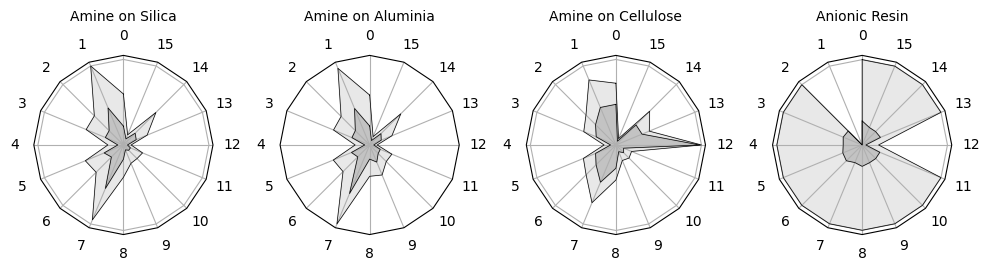

In [348]:
# normalized data (range 0-1) for comparison
fig, ax = plt.subplots(figsize=(10, 7), ncols=4, nrows=1, subplot_kw=dict(projection='radar'))
fig.subplots_adjust(top=0.85, bottom=0.05)

for en, ax in enumerate(fig.axes):
    ax.set_rgrids([0, 1, 2.0, 3.0, 4.0, 5.0, 6])
    ax.set_title(ls_material3[en], position=(0.5, 1.1), ha='center', fontsize=fs)

    line = ax.plot(theta, case_dataW[en], color='k', lw=0.5)
    ax.fill(theta, case_dataW[en], alpha=0.25, label='_nolegend_', color='#A6A6A6')
    
    line = ax.plot(theta, case_dataB[en], color='k', lw=0.5)
    ax.fill(theta, case_dataB[en], alpha=0.55, label='_nolegend_', color='#A6A6A6')
    
    ax.set_varlabels(spoke_labels)
    ax.set_yticklabels([])

plt.tight_layout()
plt.show()

# save figure
# fig.savefig(path_save + 'environmnetal_impact_adsorbents_SensitivityStudy.png', dpi=300) # total